<a href="https://colab.research.google.com/github/coder-gx/my_lcm/blob/main/lcm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# 指定当前的工作文件夹
import os
# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("/content/drive/MyDrive/LCM")


In [ ]:
!pip install --upgrade pip
!pip install --upgrade diffusers transformers accelerate peft


In [ ]:
import torch
from diffusers import LCMScheduler, AutoPipelineForText2Image

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
adapter_id = "latent-consistency/lcm-lora-sdxl"

pipe = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

# load and fuse lcm lora
pipe.load_lora_weights(adapter_id)
pipe.fuse_lora()

prompt = "beautiful girl at seaside, surrounded with flowers, 8k"

# disable guidance_scale by passing 0
image = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0).images[0]
image.save("/content/drive/MyDrive/LCM/test/test_lcm_lora_sdxl.png")

In [13]:
import torch
from diffusers import AutoPipelineForImage2Image, LCMScheduler
from diffusers.utils import make_image_grid, load_image

pipe = AutoPipelineForImage2Image.from_pretrained(
    "Lykon/dreamshaper-7",
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")

# set scheduler
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

# load LCM-LoRA
pipe.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")
pipe.fuse_lora()

# prepare image
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/img2img-init.png"
init_image = load_image(url)
prompt = "Astronauts in a jungle, cold color palette, muted colors, detailed, 8k"

# pass prompt and image to pipeline
generator = torch.manual_seed(0)
image = pipe(
    prompt,
    image=init_image,
    num_inference_steps=4,
    guidance_scale=1,
    strength=0.6,
    generator=generator
).images[0]
make_image_grid([init_image, image], rows=1, cols=2)
image.save("/content/drive/MyDrive/LCM/test/test_img2img.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import torch
import cv2
import numpy as np
from PIL import Image

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, LCMScheduler
from diffusers.utils import load_image

image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
).resize((512, 512))

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None,
    variant="fp16"
).to("cuda")

# set scheduler
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

# load LCM-LoRA
pipe.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")

generator = torch.manual_seed(0)
image = pipe(
    "the mona lisa",
    image=canny_image,
    num_inference_steps=4,
    guidance_scale=1.5,
    controlnet_conditioning_scale=0.8,
    cross_attention_kwargs={"scale": 1},
    generator=generator,
).images[0]
make_image_grid([canny_image, image], rows=1, cols=2)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/4 [00:00<?, ?it/s]

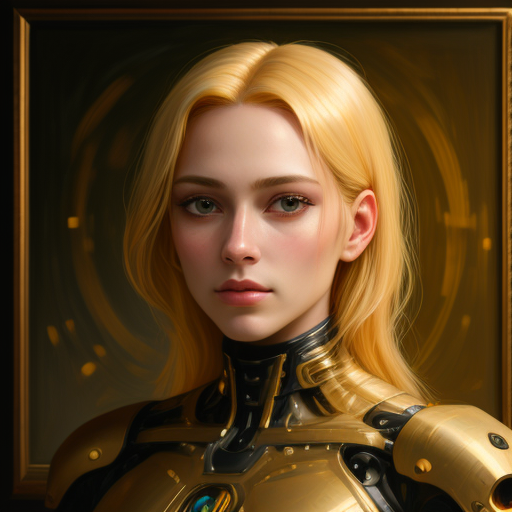

In [16]:
import torch
from diffusers import LCMScheduler, AutoPipelineForText2Image

model_id = "Lykon/dreamshaper-7"
adapter_id = "latent-consistency/lcm-lora-sdv1-5"
#adapter_id="XanderGong/my-lcm"
pipe = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

# load and fuse lcm lora
pipe.load_lora_weights(adapter_id)
pipe.fuse_lora()


prompt = "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k"

# disable guidance_scale by passing 0
image = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0).images[0]
image